In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

windows = True # If on mac put false, windows true

Can i write something which checks if it is stable? Say check the difference between the final two values say?  
have a feeling there will be an error some where. maybe the way i calculate the resistance shouldnt be for all. think about the C line.  
have worked out that it has to be under 3 delay with any alpha value.

I have also messed around with the delayed part of the euler function on this one. seems to work the same. worth going back and changing on others i reckon. or atleast should double check this worksm properly

#### data input

In [3]:
if windows == True:
    baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines_met.csv", index_col=0).rename(columns={"Q in single(m^3/s????)": "baseline Q"}) # FOR WINDOWS
else:
    baselines = pd.read_csv(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines_met.csv", index_col=0).rename(columns={"Q in single(m^3/s????)": "baseline Q"}) # FOR MAC

In [17]:
print(baselines['Q in single(µm3/s)'])

0     3.713608e+06
1     1.858585e+06
2     9.287990e+05
3     4.643641e+05
4     2.311165e+05
5     1.160077e+05
6     5.804540e+04
7     1.157009e+05
8     2.333386e+05
9     4.619354e+05
10    9.254614e+05
11    1.857643e+06
12    3.703498e+06
Name: Q in single(µm3/s), dtype: float64


#### paramaters

In [4]:
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
n=1
max_time = 2000 #standard 200
no = 5001 #standard 101
delay_pressure_drop = 15

#### work out vectors

In [5]:
t = pd.Series(np.linspace(0,max_time,no))
dt = max_time/(no-1)

#### PRessure stuff
pressure_in = pd.Series(np.zeros(len(t)))
ratio_drop = 0.5
for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    else:
        pressure_in[i] = 60 - 34.18*ratio_drop
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out

## Model

#### Functions

In [18]:
def total_R(baselines,phi,alpha):
    if phi == 0:
        C_ = 1000000000000000 # should maken a better value for infinite
    else:
        C_ = alpha*(baselines.loc[6,'Resistance for Q']/2)/phi**4 + (1-alpha)*(baselines.loc[6,'Resistance for Q']/2)
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total

def euler(alpha,delay):
    delay_number = round(delay/dt)
    
    
    R_tot = pd.Series(np.zeros(len(t)))
    Q_tot = pd.Series(np.zeros(len(t)))
    Q_norm = pd.Series(np.ones(len(t)))
    
    phi = pd.Series(np.ones(no))
    phi_min = pd.Series(np.ones(no))
    dphidt = pd.Series(np.zeros(no))
    
    for i in range(len(t)):
        if i <= delay_number:
            delayed_phi = 1
        else:
            delayed_phi = phi[i-delay_number]
        R_tot[i] = total_R(baselines,phi[i],alpha)
        Q_tot[i] = pressure_difference[i]/R_tot[i]
        Q_norm[i] = Q_tot[i] / baselines['Q in single(µm3/s)'][0]
        dphidt[i] = (alpha**1/4)*(1/optimised_value_tau)*( -delayed_phi + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
            
        if dphidt[i]*dt + phi[i] < 0:
            phi[i+1] = 0
        else:
            phi[i+1] = dphidt[i]*dt + phi[i]
                
        phi_min[i+1] = 1-(1-phi_min_baseline)*(1-Q_norm[i])**n
            
    combined = pd.DataFrame()
    combined['t'] = t
    combined['pressure_difference'] = pressure_difference
    combined['phi'] = phi
    combined['phi_min'] = phi_min
    combined['dphidt'] = dphidt
    combined['R_tot'] = R_tot
    combined['Q_tot'] = Q_tot
    combined['Q_norm'] = Q_norm
            
    return combined

#### the loop

In [19]:
min_alpha = 0
max_alpha = 1
num_alpha = 10
alpha = np.linspace(min_alpha,max_alpha,num=num_alpha)
# alpha = [0,1]

# min_delay = 1
# max_delay = 3
# num_delay = 2
# delay = np.linspace(min_delay,max_delay, num=num_delay)
delay = [1,3,7.62,10]

response = {}
yay_or_nay = pd.DataFrame()

for i in range(len(alpha)):
    for j in range(len(delay)):
        #first is alpha second is delay
        response[i,j] = euler(alpha[i],delay[j])
        if len(response[i,j][response[i,j]['phi'] < 0]) == 0:
            yay_or_nay.loc[alpha[i],delay[j]] = 1
        else:
            yay_or_nay.loc[alpha[i],delay[j]] = 0
yay_or_nay.index.name = 'alpha'
yay_or_nay = yay_or_nay.rename_axis('delay', axis=1)

#### phi checker

#### graphs

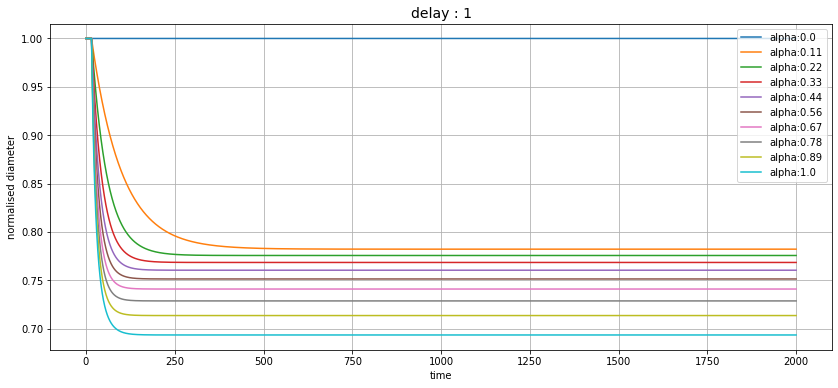

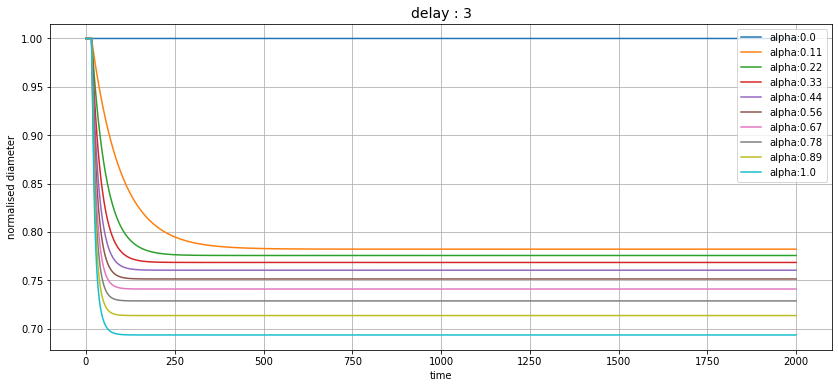

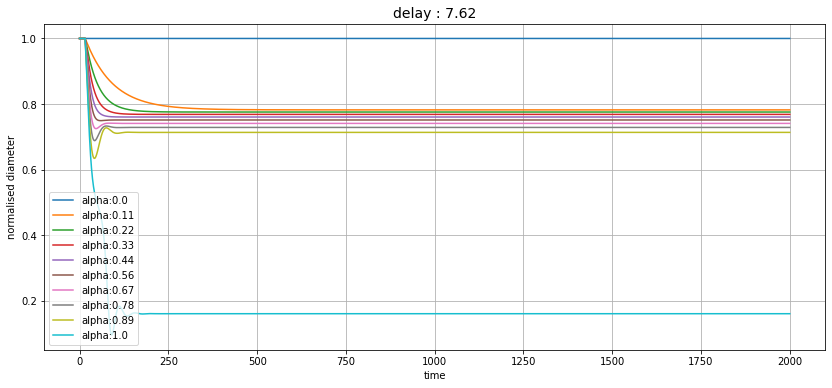

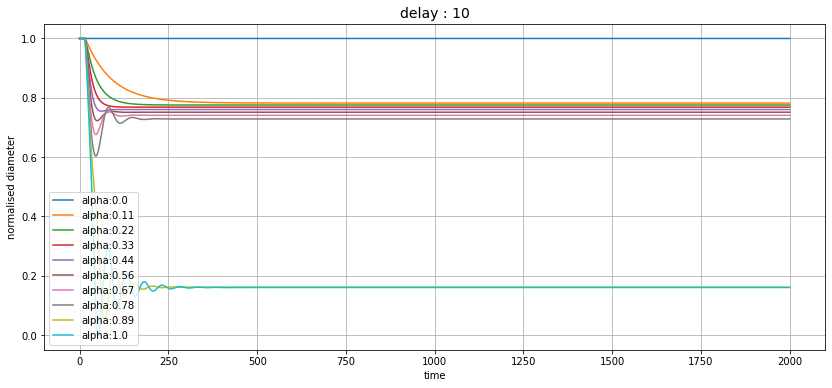

In [20]:
#set OPTION = 1 if want it to have a single value plot of delay with multiple alphas. 
#OPTION = 0 for single alpphas with multi delay
OPTION = 1

###Select which graphs
#put alpha in or delay in if you want the whole range. or put the index of the ones you want eg. [0,4,6,8,9,10]
# delay_graph = [0,1,2,3,4,5,6,7,8,9]
delay_graph = np.arange(0,len(delay),1)
# alpha_graph = [0,1,2,3,4]
alpha_graph = np.arange(0,len(alpha),1)

fig = {}
ax = {}

if OPTION == 1 :
    for j in range(len(delay_graph)):
        fig[j],ax[j] = plt.subplots(figsize=(14,6))
        for i in range(len(alpha_graph)):
            ax[j] = plt.plot(response[alpha_graph[i],delay_graph[j]]['t'],response[alpha_graph[i],delay_graph[j]]['phi'][0:len(t)],label='alpha:{}' .format(round(alpha[alpha_graph[i]], ndigits=2)))
        fig[j] = plt.ylabel('normalised diameter')
        fig[j] = plt.xlabel('time')
        #ax[j] = plt.ylim(bottom=-0.5, top=1.5)
        fig[j] = plt.title('delay : {}' .format(delay[delay_graph[j]]), fontsize=14)
        fig[j] = plt.legend()
        fig[j] = plt.grid(which='both')
        
elif OPTION == 0 :
    for i in range(len(alpha_graph)):
        fig[i],ax[i] = plt.subplots(figsize=(14,6))
        for j in range(len(delay_graph)):
            ax[i] = plt.plot(response[alpha_graph[i],delay_graph[j]]['t'],response[alpha_graph[i],delay_graph[j]]['phi'][0:len(t)],label='delay:{}' .format(round(delay[delay_graph[j]], ndigits=4)))
        fig[i] = plt.ylabel('normalised diameter')
        fig[i] = plt.xlabel('time')
        ax[j] = plt.ylim(bottom=-0.5, top=1.5)
        fig[i] = plt.title('alpha : {}' .format(alpha[alpha_graph[i]]), fontsize=14)
        fig[i] = plt.legend()
        fig[i] = plt.grid(which='both')